 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# CellphoneDB method 3 (differential expression)  
In this example we are using the method 3 (`degs_analysis_method`) to study how cell-cell interactions change between perivascular cells (PVs) and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This method will retrieve interactions where at least one of the interacting partners (genes involved in the interaction) is differentially expressed. 

> The **differentially expressed genes should be pre-computed by the users** using their preferred methodology (e.g. Limma, DEseq2, Seurat, TradeSeq, etc), and pass the significant results to CellphoneDB in a predefined tabular format.


This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. In this notebook we will explain how to run CellphoneDB for the **differential expression method**.

### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)
# Define our base directory for the analysis
os.chdir('/home/jovyan/cpdb_tutorial')

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]


### Install CellphoneDB

Installing last version of CellphoneDB in the current conda enviroment. \
Remove the `--quiet` flag in case you want to see a detailed description of the installation process.

> pip install --quiet cellphonedb

___
### Input files
The differential expression method accepts 6 input files (4 mandatory).
- **cpdb_file_path**: (mandatory) path to the database.
- **meta_file_path**: (mandatory) path to the meta file linking cell barcodes to cluster labels.
- **counts_file_path**: (mandatory) paths to normalized counts file (not z-transformed), either in text format or h5ad (recommended).
- **degs_file_path**: (mandatory) path to the DEG file indicating the differentially expressed genes in each cluster. Only differentially expressed genes that are significant should be included.
- **microenvs_file_path**: (optional) path to microenvironment file that groups cell types/clusters by microenvironments. When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.
- **active_tf_path**: (optional) to the active transcription factors.

Both, `degs_file_path` and `microenvs_file_path` content will depend on the biological question that the researcher wants to answer.


> In **this example** we are studying how cell-cell interactions change between perivascular cells (PVs) and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. Therefore, the `degs_file_path` contains only the genes differentially expressed along the trophoblast differentiation lineage as we are interested in those cell-cell communication processes that change along this differentiation process. The `microenvs_file_path` contains only cells present in a specific anatomical region of the placenta (i.e. PVs and trophoblast cell states in the same spatiotemporal neighborhood). The `meta_file_path` and `counts_file_path` contain all the PVs and trophoblast that we are interested in.

> CellphoneDB will retrieve all the interactions occurring between PVs and trophoblast where: (i) all the proteins are expressed in the corresponding cell type and (ii) at least one gene is differentially expressed by the trophoblast.

In [3]:
cpdb_file_path = 'db/v5/cellphonedb.zip'
meta_file_path = 'data/metadata.tsv'
counts_file_path = 'data/normalised_log_counts.h5ad'
microenvs_file_path = 'data/microenvironment.tsv'
degs_file_path = 'data/DEGs_inv_trophoblast.tsv'
active_tf_path = 'data/active_TFs.tsv'
out_path = 'results/method3_withScore'

### Inspect input files

<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,barcode_sample,cell_type
0,AGCGATTAGTCTAACC-1_Pla_HDBR10917733,B_cells
1,ATCCGTGAGGCTAGAA-1_Pla_Camb10714918,B_cells
2,AGTAACCCATTAAAGG-1_Pla_HDBR10917733,B_cells


<span style="color:green">**2)**</span>  The **counts** files is a h5ad object from scanpy. The dimensions and order of this object must coincide with the dimensions of the metadata file, i.e. must have the same number of cells in both files.

In [5]:
import anndata

adata = anndata.read_h5ad('/home/jovyan/cpdb_tutorial/data/normalised_log_counts.h5ad')
adata.shape

(3312, 30800)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['barcode_sample']) \
    .sort()

True

<span style="color:green">**3)**</span> **Differentially expressed genes** file s is a two columns file indicanting which gene up-regulated (or specific) in a cell type. The **first column** corresponds to the cluster name (these match with those in the metadata file) and the **second column** the up-regulated gene. The remaining columns are ignored by CellphoneDB. All genes present in this file will be taken into account, thus the user must provide in this file only those genes considered as up-regulated or relevant for the analysis.

In [7]:
pd.read_csv(degs_file_path, sep = '\t') \
    .head(3)

,cell_type,gene,logFC,P.Value,adj.P.Val
0,GC,BGN,1.605019,3.950450e-131,4.844832e-127
1,GC,HLA-G,1.412923,5.616884e-254,6.888547e-250
2,GC,B2M,1.358709,0.000000e+00,0.000000e+00


<span style="color:green">**4)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironment. CellphoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining just one microenvionment.

In [8]:
microenv = pd.read_csv(microenvs_file_path,
                       sep = '\t')
microenv.head(3)

,cell_type,microenvironment
0,PV MMP11,Env1
1,PV MYH11,Env1
2,PV STEAP4,Env1


Displaying cells grouped per microenvironment

In [9]:
microenv.groupby('microenvironment')['cell_type'].apply(lambda x : list(x.value_counts().index))

microenvironment
Env1    [PV MMP11, PV MYH11, PV STEAP4, EVT_1, EVT_2, ...
Name: cell_type, dtype: object

<span style="color:green">**5)**</span> **Active transcription factors** defines trancription factors active in a given cell type.

In [10]:
pd.read_csv(active_tf_path, sep = '\t') \
    .head(3)

,cell_type,TF
0,EVT_1,ASCL2
1,EVT_1,ELK3
2,EVT_1,GATA3


____
### Run CellphoneDB with differential analysis (method 3)
The output of this method will be saved in `output_path` and also assigned to the predefined variables.

In [11]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method

cpdb_results = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,                      # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )

[ ][CORE][29/08/23-14:33:21][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
data/normalised_log_counts.h5ad
data/metadata.tsv
data/microenvironment.tsv
data/active_TFs.tsv
data/DEGs_inv_trophoblast.tsv
[ ][CORE][29/08/23-14:33:24][INFO] Running Real Analysis
[ ][CORE][29/08/23-14:33:24][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][29/08/23-14:33:24][INFO] Running DEGs-based Analysis
[ ][CORE][29/08/23-14:33:24][INFO] Building results
[ ][CORE][29/08/23-14:33:25][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 42/42 [00:00<00:00, 238.07it/s]

[ ][CORE][29/08/23-14:33:25][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 42/42 [00:00<00:00, 726.74it/s]


[ ][CORE][29/08/23-14:33:26][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 81/81 [00:04<00:00, 16.71it/s]


Saved deconvoluted to results/method3_withScore/degs_analysis_deconvoluted_08_29_2023_143331.txt
Saved deconvoluted_percents to results/method3_withScore/degs_analysis_deconvoluted_percents_08_29_2023_143331.txt
Saved means to results/method3_withScore/degs_analysis_means_08_29_2023_143331.txt
Saved relevant_interactions to results/method3_withScore/degs_analysis_relevant_interactions_08_29_2023_143331.txt
Saved significant_means to results/method3_withScore/degs_analysis_significant_means_08_29_2023_143331.txt
Saved CellSign_active_interactions to results/method3_withScore/degs_analysis_CellSign_active_interactions_08_29_2023_143331.txt
Saved CellSign_active_interactions_deconvoluted to results/method3_withScore/degs_analysis_CellSign_active_interactions_deconvoluted_08_29_2023_143331.txt
Saved interaction_scores to results/method3_withScore/degs_analysis_interaction_scores_08_29_2023_143331.txt


Results are save as files and as a dictionary in the `cpdb_results` variable.

In [12]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'relevant_interactions',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted',
 'interaction_scores']

___
### Description of output files
Most output files share common columns:
- **id_cp_interaction**: Unique CellphoneDB identifier for each interaction stored in the database.
- **interacting_pair**: Name of the interacting pairs separated by “|”.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **secreted**: True if one of the partners is secreted.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellphoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
- **is_integrin**: True if one of the partners is integrin.
- **directionality**: Indiicates the directionality of the interaction and the charactersitics of the interactors.
- **classification**: Pathway classification for the interacting partners.

**Relevant interaction** fields:
- **cell_a|cell_b**: 1 if interaction is detected as significant, 0 if not.

In [13]:
cpdb_results['relevant_interactions'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Significant means** fields:
- **significant_mean**: Significant mean calculation for all the interacting partners. If the interaction has been found relevant, the value will be the mean. Alternatively, the value is set to 0.

In [14]:
cpdb_results['significant_means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,rank,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
2627,CPI-SC0DFEAE26D,WNT7A_FZD6_LRP5,simple:O00755,complex:FZD6_LRP5,WNT7A,NaN,True,False,False,curated,False,Ligand-Receptor,Signaling by WNT,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2585,CPI-SC0FBD05A5F,WNT2B_FZD5_LRP5,simple:Q93097,complex:FZD5_LRP5,WNT2B,NaN,True,False,False,curated,False,Ligand-Receptor,Signaling by WNT,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Means** fields:
- **means**: Mean values for all the interacting partners: mean value refers to the total mean of the individual partner average expression values in the corresponding interacting pairs of cell types. If one of the mean values is 0, then the total mean is set to 0.

In [15]:
cpdb_results['means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105,0.0,0.0,0.071,0.099,0.089,0.077,0.099,0.346,0.077,0.0,0.0,0.043,0.071,0.060,0.048,0.070,0.317,0.131,0.0,0.0,0.097,0.125,0.115,0.102,0.124,0.371,0.194,0.0,0.0,0.160,0.188,0.177,0.165,0.187,0.434,0.321,0.0,0.0,0.287,0.315,0.305,0.292,0.314,0.561,0.193,0.0,0.0,0.159,0.187,0.177,0.164,0.186,0.433,0.232,0.0,0.0,0.198,0.225,0.215,0.203,0.225,0.472
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.041,0.0,0.0,0.006,0.034,0.024,0.012,0.034,0.281,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.0,0.0,0.009,0.037,0.026,0.014,0.036,0.283,0.042,0.0,0.0,0.007,0.035,0.025,0.013,0.035,0.282,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.049,0.0,0.0,0.015,0.043,0.032,0.020,0.042,0.289


**Deconvoluted** fields:
- **gene_name**: Gene identifier for one of the subunits that are participating in the interaction defined in “means.csv” file. The identifier will depend on the input of the user list.
- **uniprot**: UniProt identifier for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **is_complex**: True if the subunit is part of a complex. Single if it is not, complex if it is.
- **protein_name**: Protein name for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **complex_name**: Complex name if the subunit is part of a complex. Empty if not.
- **id_cp_interaction**: Unique CellphoneDB identifier for each of the interactions stored in the database.
- **mean**: Mean expression of the corresponding gene in each cluster.

In [16]:
cpdb_results['deconvoluted'].head(2)

,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,gene,B_cells,DC,EVT_1,EVT_2,Endo_F,Endo_L,Endo_M,GC,Granulocytes,HOFB,ILC3,M3,MO,NK,PV MMP11,PV MYH11,PV STEAP4,Plasma,SCT,T_cells,VCT,VCT_CCC,VCT_fusing,VCT_p,dDC,dEpi_lumenal,dEpi_secretory,dM1,dM2,dNK1,dNK2,dNK3,dS1,dS2,dS3,dT_cells,dT_regs,eEVT,fF1,fF2,iEVT,uSMC
multidata_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,UBASH3B,0.24,0.0,0.621,1.06,0.105,0.212,0.216,1.424,0.0,0.411,0.25,0.465,0.068,0.127,0.114,0.0,0.0,0.0,0.161,0.0,0.484,0.576,0.158,0.454,0.608,0.0,0.124,0.24,0.36,1.134,0.632,0.437,0.118,0.224,0.162,0.025,0.124,1.182,0.055,0.0,1.402,0.338
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS05760BB78,UBASH3B,0.24,0.0,0.621,1.06,0.105,0.212,0.216,1.424,0.0,0.411,0.25,0.465,0.068,0.127,0.114,0.0,0.0,0.0,0.161,0.0,0.484,0.576,0.158,0.454,0.608,0.0,0.124,0.24,0.36,1.134,0.632,0.437,0.118,0.224,0.162,0.025,0.124,1.182,0.055,0.0,1.402,0.338


**Interaction scores** fields:
- **scores**: scores ranging from 0 to 100. The higher the score is,  the more specific the interaction is expected to be.

In [17]:
cpdb_results['interaction_scores'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.391
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


**CellSign** fields:
- **interacting_pair**: Name of the interacting pairs.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **TF relationship**: a 1 denotes that the TF downstream the receptor is active.

In [18]:
cpdb_results['CellSign_active_interactions'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SS076940BCD,LGALS3_MERTK,simple:P17931,simple:Q12866,LGALS3,MERTK,True,False,True,curated,False,Ligand-Receptor,Signaling by Galectin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CPI-SS007AA9FDE,DLK1_NOTCH3,simple:P80370,simple:Q9UM47,DLK1,NOTCH3,False,False,True,curated,False,Ligand-Receptor,Signaling by Notch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Explore CellphoneDB results
This module allows to filter CellphoneDB results by specifying: cell types pairs, genes or specific interactions.

We can specify two list of cell types (`query_cell_type_1`and `query_cell_type_2`), the method will perform a pairwise comparison between the cell types defined in each list and will subset the interactions to those pairs of cells. Cell types within each list will not be paired. If we are interested in filtering interactions ocurring between a given cell to all the rest of cells in the dataset we can define `query_cell_type_1 = 'All'` and `query_cell_type_2 = ['cellA', 'cellB', ...]`. The argument `genes` allows the user to filter interactions in which a gene participates, the users can also define specific interactions based on the interaction name `query_interactions`.

> In **this example** we are going to filter interactions in which a subset of trophoblast interact with the PV cells, furthermore, we will select those interactions in which the gene TGFBR1 participates and a specific interaction named CSF1_CSF1R.

This method filters the rows and columns of the significant_means file; NaN value correspond to interacting pairs found not significant, non-NaN value correspond to those interacting pairs found relevant.

In [19]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['EVT_1', 'EVT_2', 'GC', 'eEVT', 'iEVT'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['PV MMP11', 'PV MYH11', 'PV STEAP4'],     # List of cells 2, will be paired to cells 1 (list or 'All').
    query_genes = ['TGFBR1'],                                       # filter interactions based on the genes participating (list).
    query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    query_classifications = ['Signaling by Transforming growth factor']
)

search_results.head(3)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
1,CSF1_CSF1R,simple:P09603,simple:P07333,CSF1,CSF1R,Ligand-Receptor,Signaling by Colony-Stimulating factor,PV MMP11|EVT_1,0.187
3,TGFB3_TGFbeta_receptor2,simple:P10600,complex:TGFbeta_receptor2,TGFB3,NaN,Ligand-Receptor,Signaling by Transforming growth factor,PV MMP11|EVT_1,0.220
6,TGFB3_TGFbeta_receptor1,simple:P10600,complex:TGFbeta_receptor1,TGFB3,NaN,Ligand-Receptor,Signaling by Transforming growth factor,PV MMP11|EVT_1,0.249


### Basic analysis and plotting
In this section we will do a basic analysis and plotting of the results that CellphoneDB has returned. It is of great importance that the user is familiarized with the biological context of the data to get meaninful results from CellphoneDB results. 

Cell-cell interaction data can be plotted in multiple way; chord plots/heatmaps describing the number of relevant interactions found between pairs of cells or dot plots denoting the specific partners and interacting cells among others. In this section we opt for the dot plots as these offer detailed information of the interactions and interectors.

First, we transform the results of `relevant_interactions` and `means` into a long table as this more convenient to workd and this input format of most plotting libraries.

In [20]:
# -- Get annotation columns and interactions 
annotation = list(cpdb_results['relevant_interactions'].columns[:13])
interaction = list(cpdb_results['relevant_interactions'].columns[13:])


# -- Convert relevant_interactions file from wide to long
relevant_interactions_long = pd.melt(cpdb_results['relevant_interactions'],
                                     id_vars = annotation,
                                     var_name = 'Interacting_cell',
                                     value_vars = interaction,
                                     value_name = 'Relevance')

relevant_interactions_long[['Cell_a', 'Cell_b']] = relevant_interactions_long['Interacting_cell'] \
    .str.split('|', expand = True) \
    .rename(columns={0 : 'Cell_a', 1: 'Cell_b'})

relevant_interactions_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance,Cell_a,Cell_b
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,PV MMP11|EVT_1,0,PV MMP11,EVT_1
1,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,PV MMP11|EVT_1,0,PV MMP11,EVT_1
2,CPI-SC0B86B7CED,COL12A1_integrin_a2b1_complex,simple:Q99715,complex:integrin_a2b1_complex,COL12A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,PV MMP11|EVT_1,0,PV MMP11,EVT_1


In [21]:
# -- Convert means file from wide to long
means_long = pd.melt(cpdb_results['means'],
                     id_vars = annotation,
                     var_name = 'Interacting_cell',
                     value_vars = interaction,
                     value_name = 'Mean')

means_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Mean
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,PV MMP11|EVT_1,0.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,PV MMP11|EVT_1,0.0
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,PV MMP11|EVT_1,0.0


### Sort interaction by recurrence

To facilitate the selection of interactions of interest we will calculate the recurrence of each interaction (i.e. number of times an interaction appears as relevant across all interacting partners). Here, we assume that we are interested in interactions that are specific (i.e. interactions found between a limited number of cells). This table  with the help of prior knowledge, corroborations with other dataset (i.e visium, imaging ...) select/validate the most relevant interactions.

In [22]:
# -- Create a dictionary with recurrence of relevance of any give interaction
id_cp_dict = relevant_interactions_long.groupby('id_cp_interaction')['Relevance'] \
    .sum() \
    .to_dict()

# -- Add new column to indicante the recurrence of an interaction
relevant_interactions_long['Recurrence'] = relevant_interactions_long['id_cp_interaction'] \
    .map(id_cp_dict)

# -- Sort according to the recurrence
relevant_interactions_long = relevant_interactions_long.sort_values(['Recurrence'],
                                                                    ascending = True)

relevant_interactions_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance,Cell_a,Cell_b,Recurrence
24960,CPI-SS08BFFB96E,FLRT3_ADGRL2,simple:Q9NZU0,simple:O95490,FLRT3,ADGRL2,False,False,True,curated,False,Ligand-Receptor,Signaling by Fibronectin,GC|iEVT,0,GC,iEVT,1
12809,CPI-SS08BFFB96E,FLRT3_ADGRL2,simple:Q9NZU0,simple:O95490,FLRT3,ADGRL2,False,False,True,curated,False,Ligand-Receptor,Signaling by Fibronectin,EVT_2|EVT_1,0,EVT_2,EVT_1,1
12814,CPI-SC0CF28722B,LGALS9_BCR_CD45_CD22,simple:O00182,complex:BCR_CD45_CD22,LGALS9,NaN,True,False,True,curated,False,Ligand-Receptor,Signaling by Galectin,EVT_2|EVT_1,0,EVT_2,EVT_1,1


Based on our own knowledge and corroboration with experimental data we have select a set of interactions with the following ids.

In [23]:
interactions_to_plot = ['CPI-SC0F36DD437', 'CPI-SC06C3BA86F', 'CPI-SS0AB1F04A0', 'CPI-SC051FC855D', 'CPI-SC0DABCC4B5']

idx = [ id in interactions_to_plot for id in relevant_interactions_long['id_cp_interaction'] ]
relevant_interactions_plot = relevant_interactions_long[idx].copy()

Now we add the mean expression of the interacting partners from the `means` table that we have previously modified to a long format. As the mean values of different interacting partners cannot be directly compared to those values from other interacting partners we recommend normalizing it within each interaction. In this case we apply a z-scale normalization. 

In [24]:
from scipy.stats import zscore

# -- Add mean value of the interacting partners
relevant_interactions_plot = relevant_interactions_plot.merge(means_long[['id_cp_interaction', 'Interacting_cell', 'Mean']],
                                                              on = ['id_cp_interaction', 'Interacting_cell'],
                                                              how = 'inner')

Befor applying the z-scale normalization we will remove interactions in which both partners are trophoblasts

In [25]:
import itertools

list_trophoblast = ['EVT_1', 'EVT_2', 'GC', 'VCT_CCC', 'eEVT', 'iEVT']
interact_rm = [ '|'.join(i) for i in itertools.product(list_trophoblast, repeat = 2) ]

# -- Interactions to keep
idx_keep = [ i not in interact_rm for i in relevant_interactions_plot['Interacting_cell'] ]
relevant_interactions_plot = relevant_interactions_plot[idx_keep]

In [26]:
# -- Scale within interaction
relevant_interactions_plot['Mean_scaled'] = relevant_interactions_plot.groupby('id_cp_interaction', group_keys = False)['Mean'].transform(lambda x : zscore(x, ddof = 1))
relevant_interactions_plot = relevant_interactions_plot.sort_values('Interacting_cell')

relevant_interactions_plot.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance,Cell_a,Cell_b,Recurrence,Mean,Mean_scaled
19,CPI-SS0AB1F04A0,CSF1_CSF1R,simple:P09603,simple:P07333,CSF1,CSF1R,True,False,True,curated,False,Ligand-Receptor,Signaling by Colony-Stimulating factor,EVT_1|PV MMP11,0,EVT_1,PV MMP11,4,0.000,-0.887464
309,CPI-SC06C3BA86F,FN1_integrin_a5b1_complex,simple:P02751,complex:integrin_a5b1_complex,FN1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Fibronectin,EVT_1|PV MMP11,1,EVT_1,PV MMP11,64,1.149,-0.140185
195,CPI-SC0F36DD437,TGFB2_TGFbeta_receptor2,simple:P61812,complex:TGFbeta_receptor2,TGFB2,NaN,True,False,True,curated,False,Ligand-Receptor,Signaling by Transforming growth factor,EVT_1|PV MMP11,1,EVT_1,PV MMP11,25,0.115,-0.013711


Dot plot of the selected candidates

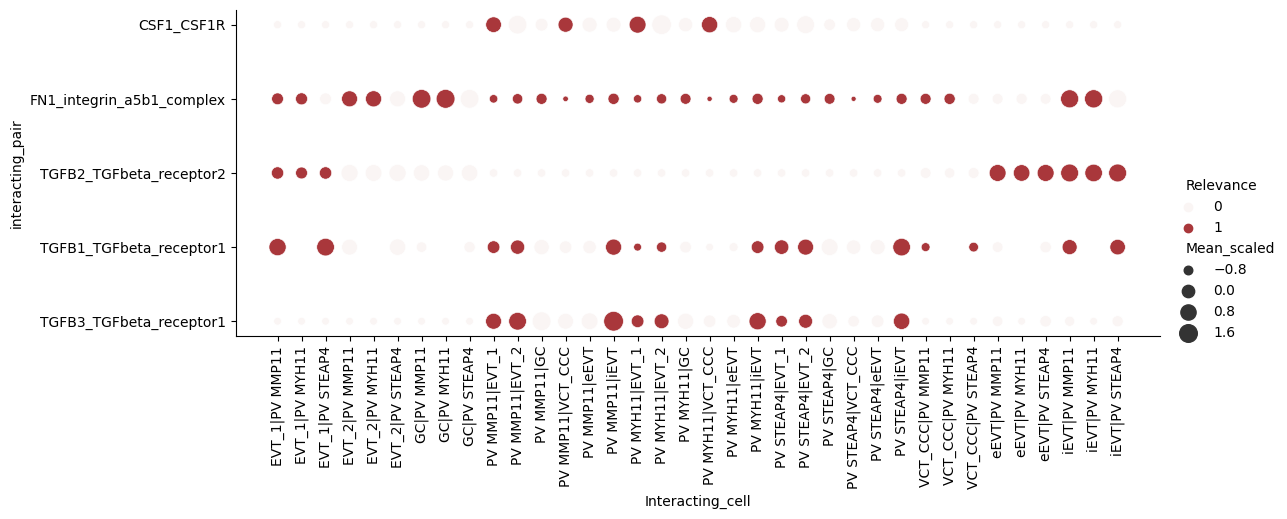

In [27]:
import seaborn as sns

g = sns.relplot(
    data = relevant_interactions_plot,
    x = "Interacting_cell",
    y = "interacting_pair",
    hue = "Relevance",
    size = "Mean_scaled",
    palette = "vlag",
    hue_norm=(-1, 1),
    height = 4,
    aspect = 3,
    sizes = (0, 200)
)
g.set_xticklabels(rotation = 90)

Alternatively, we can make use of of Kelvin's implementations ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellphoneDB outputs. In this example we will plot the interactions between PVs and the trophoblasts that are mediated by TGFB2 and CSF1R.

In [28]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

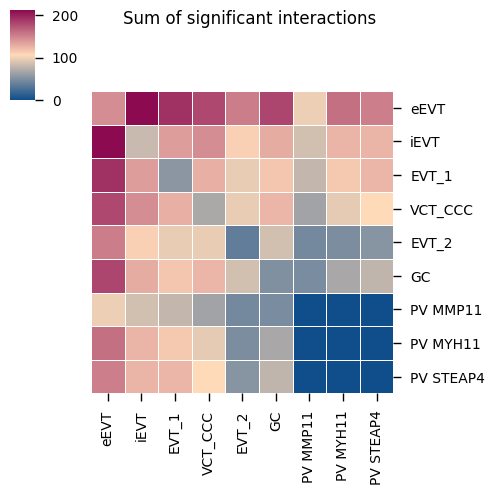

In [29]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      figsize=(5, 5),
                      title="Sum of significant interactions")

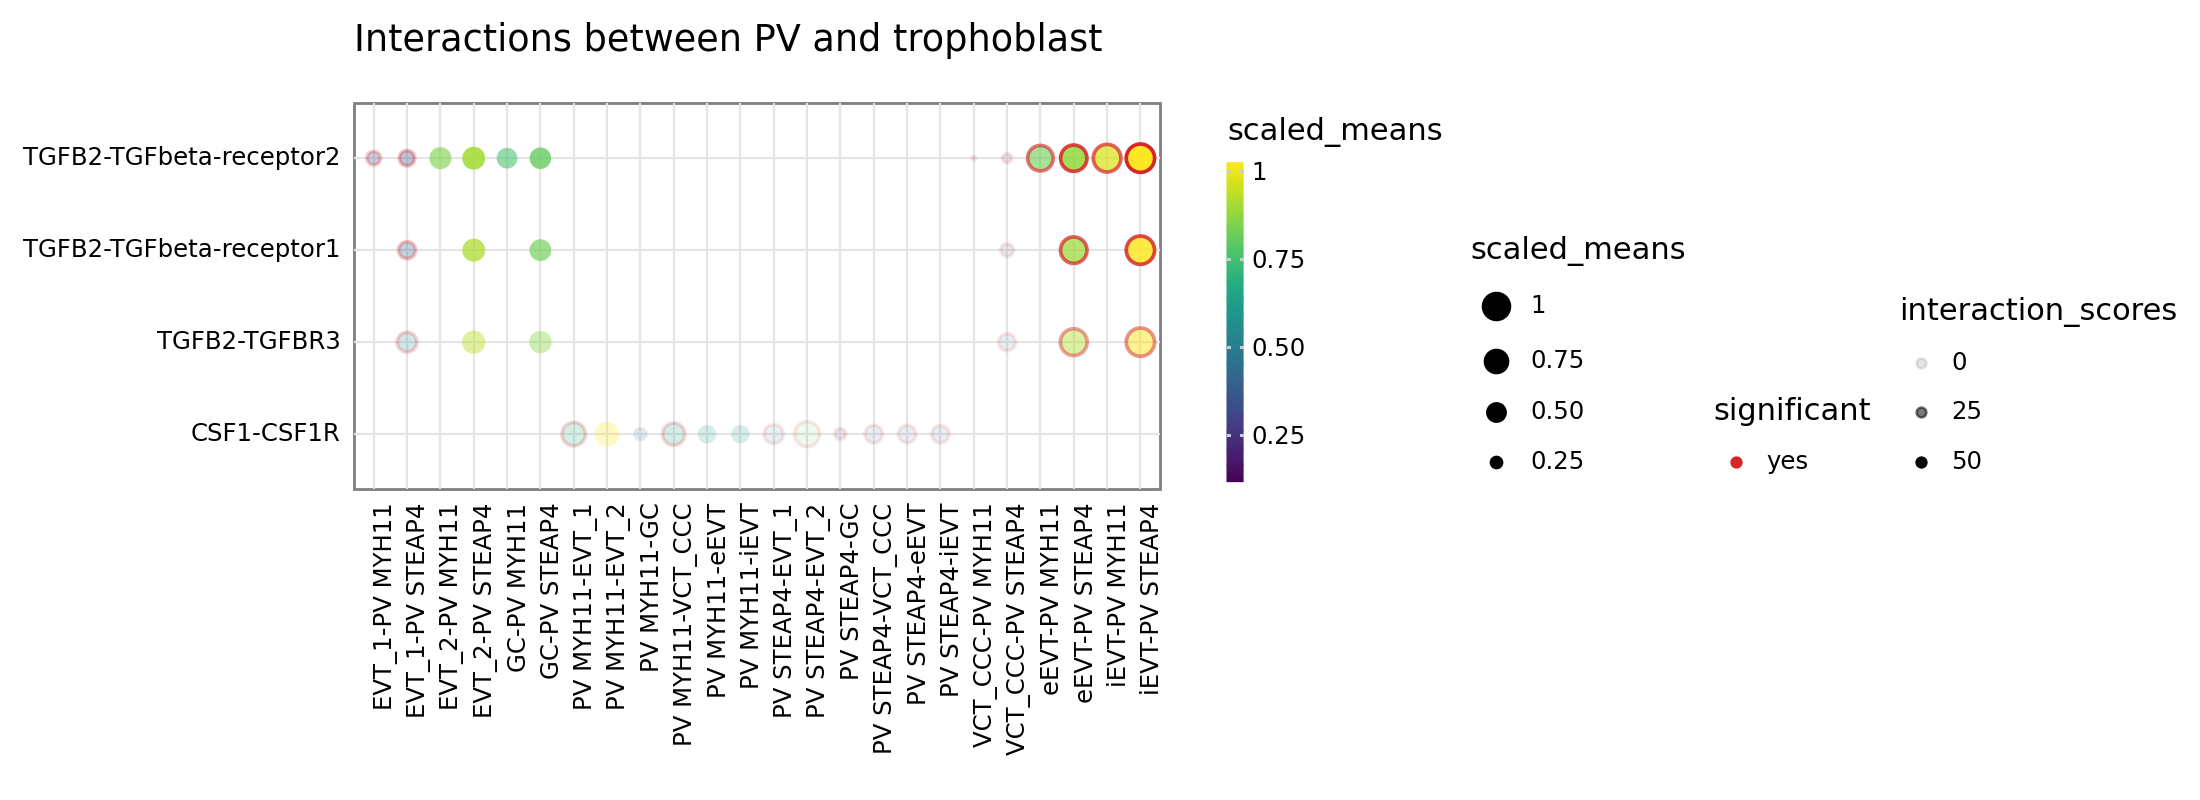

<Figure Size: (1100 x 400)>

In [30]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11|PV STEAP4|PV MMPP11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_labels",
    genes = ["TGFB2", "CSF1R"],
    figsize = (11,4),
    title = "Interactions between PV and trophoblast ",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

Ploting interactions account for CellSign results (active TFs downstream the receptor).

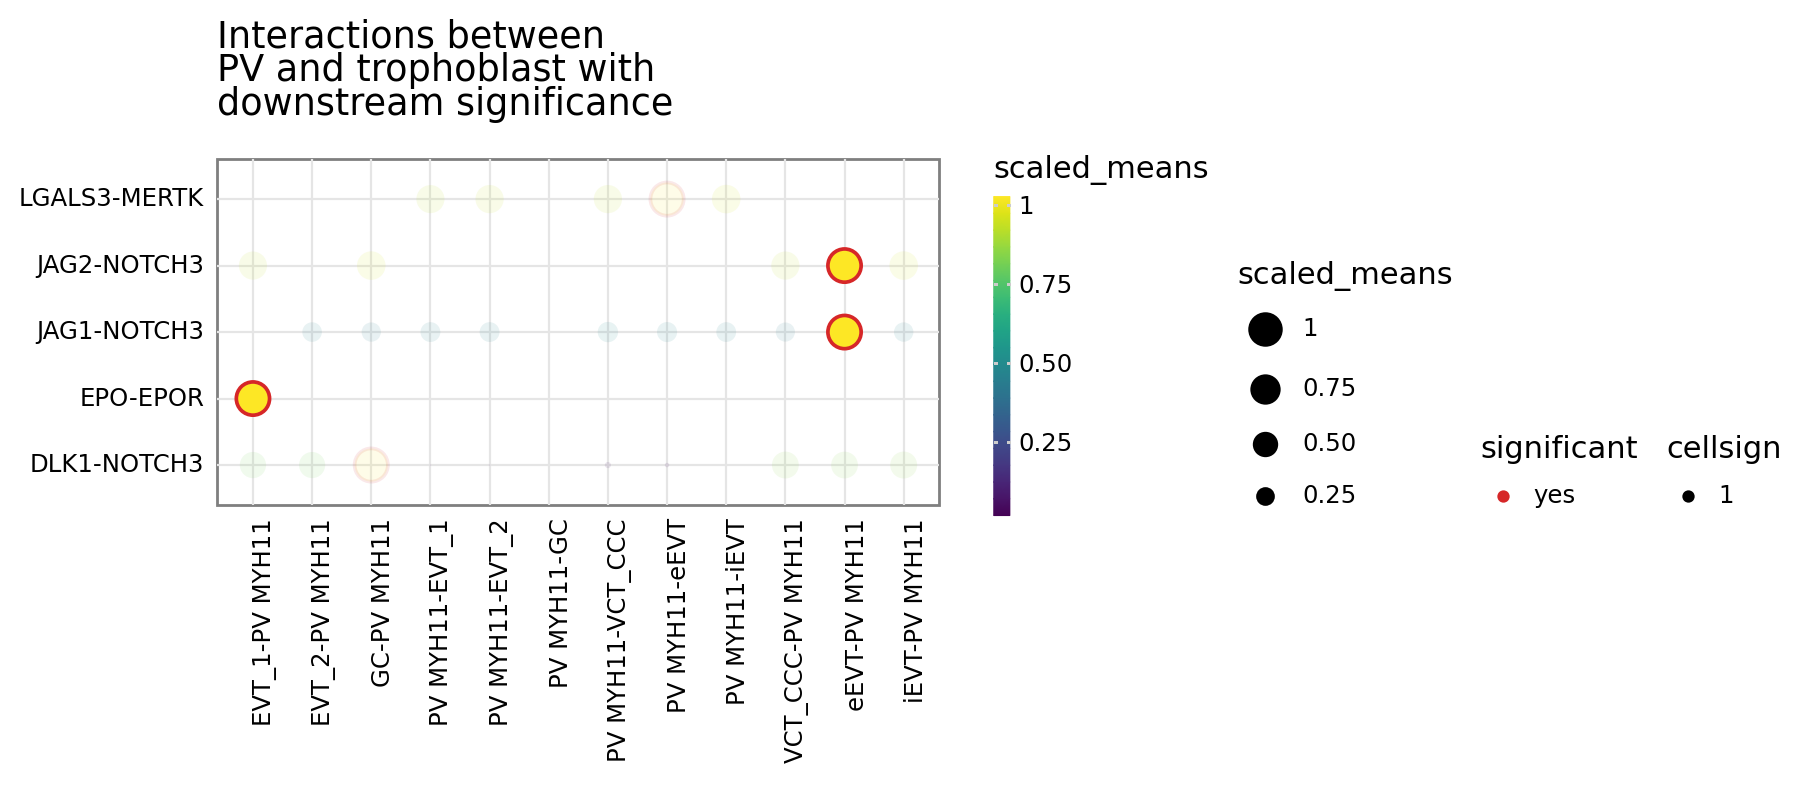

<Figure Size: (900 x 400)>

In [31]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC",
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_labels",
    figsize = (9, 4),
    title = "Interactions between\nPV and trophoblast with\ndownstream significance",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
    cellsign = cpdb_results['CellSign_active_interactions'],
    filter_by_cellsign = True,
    scale_alpha_by_cellsign = True
)

Interactions can also be plotted grouped by pathway.

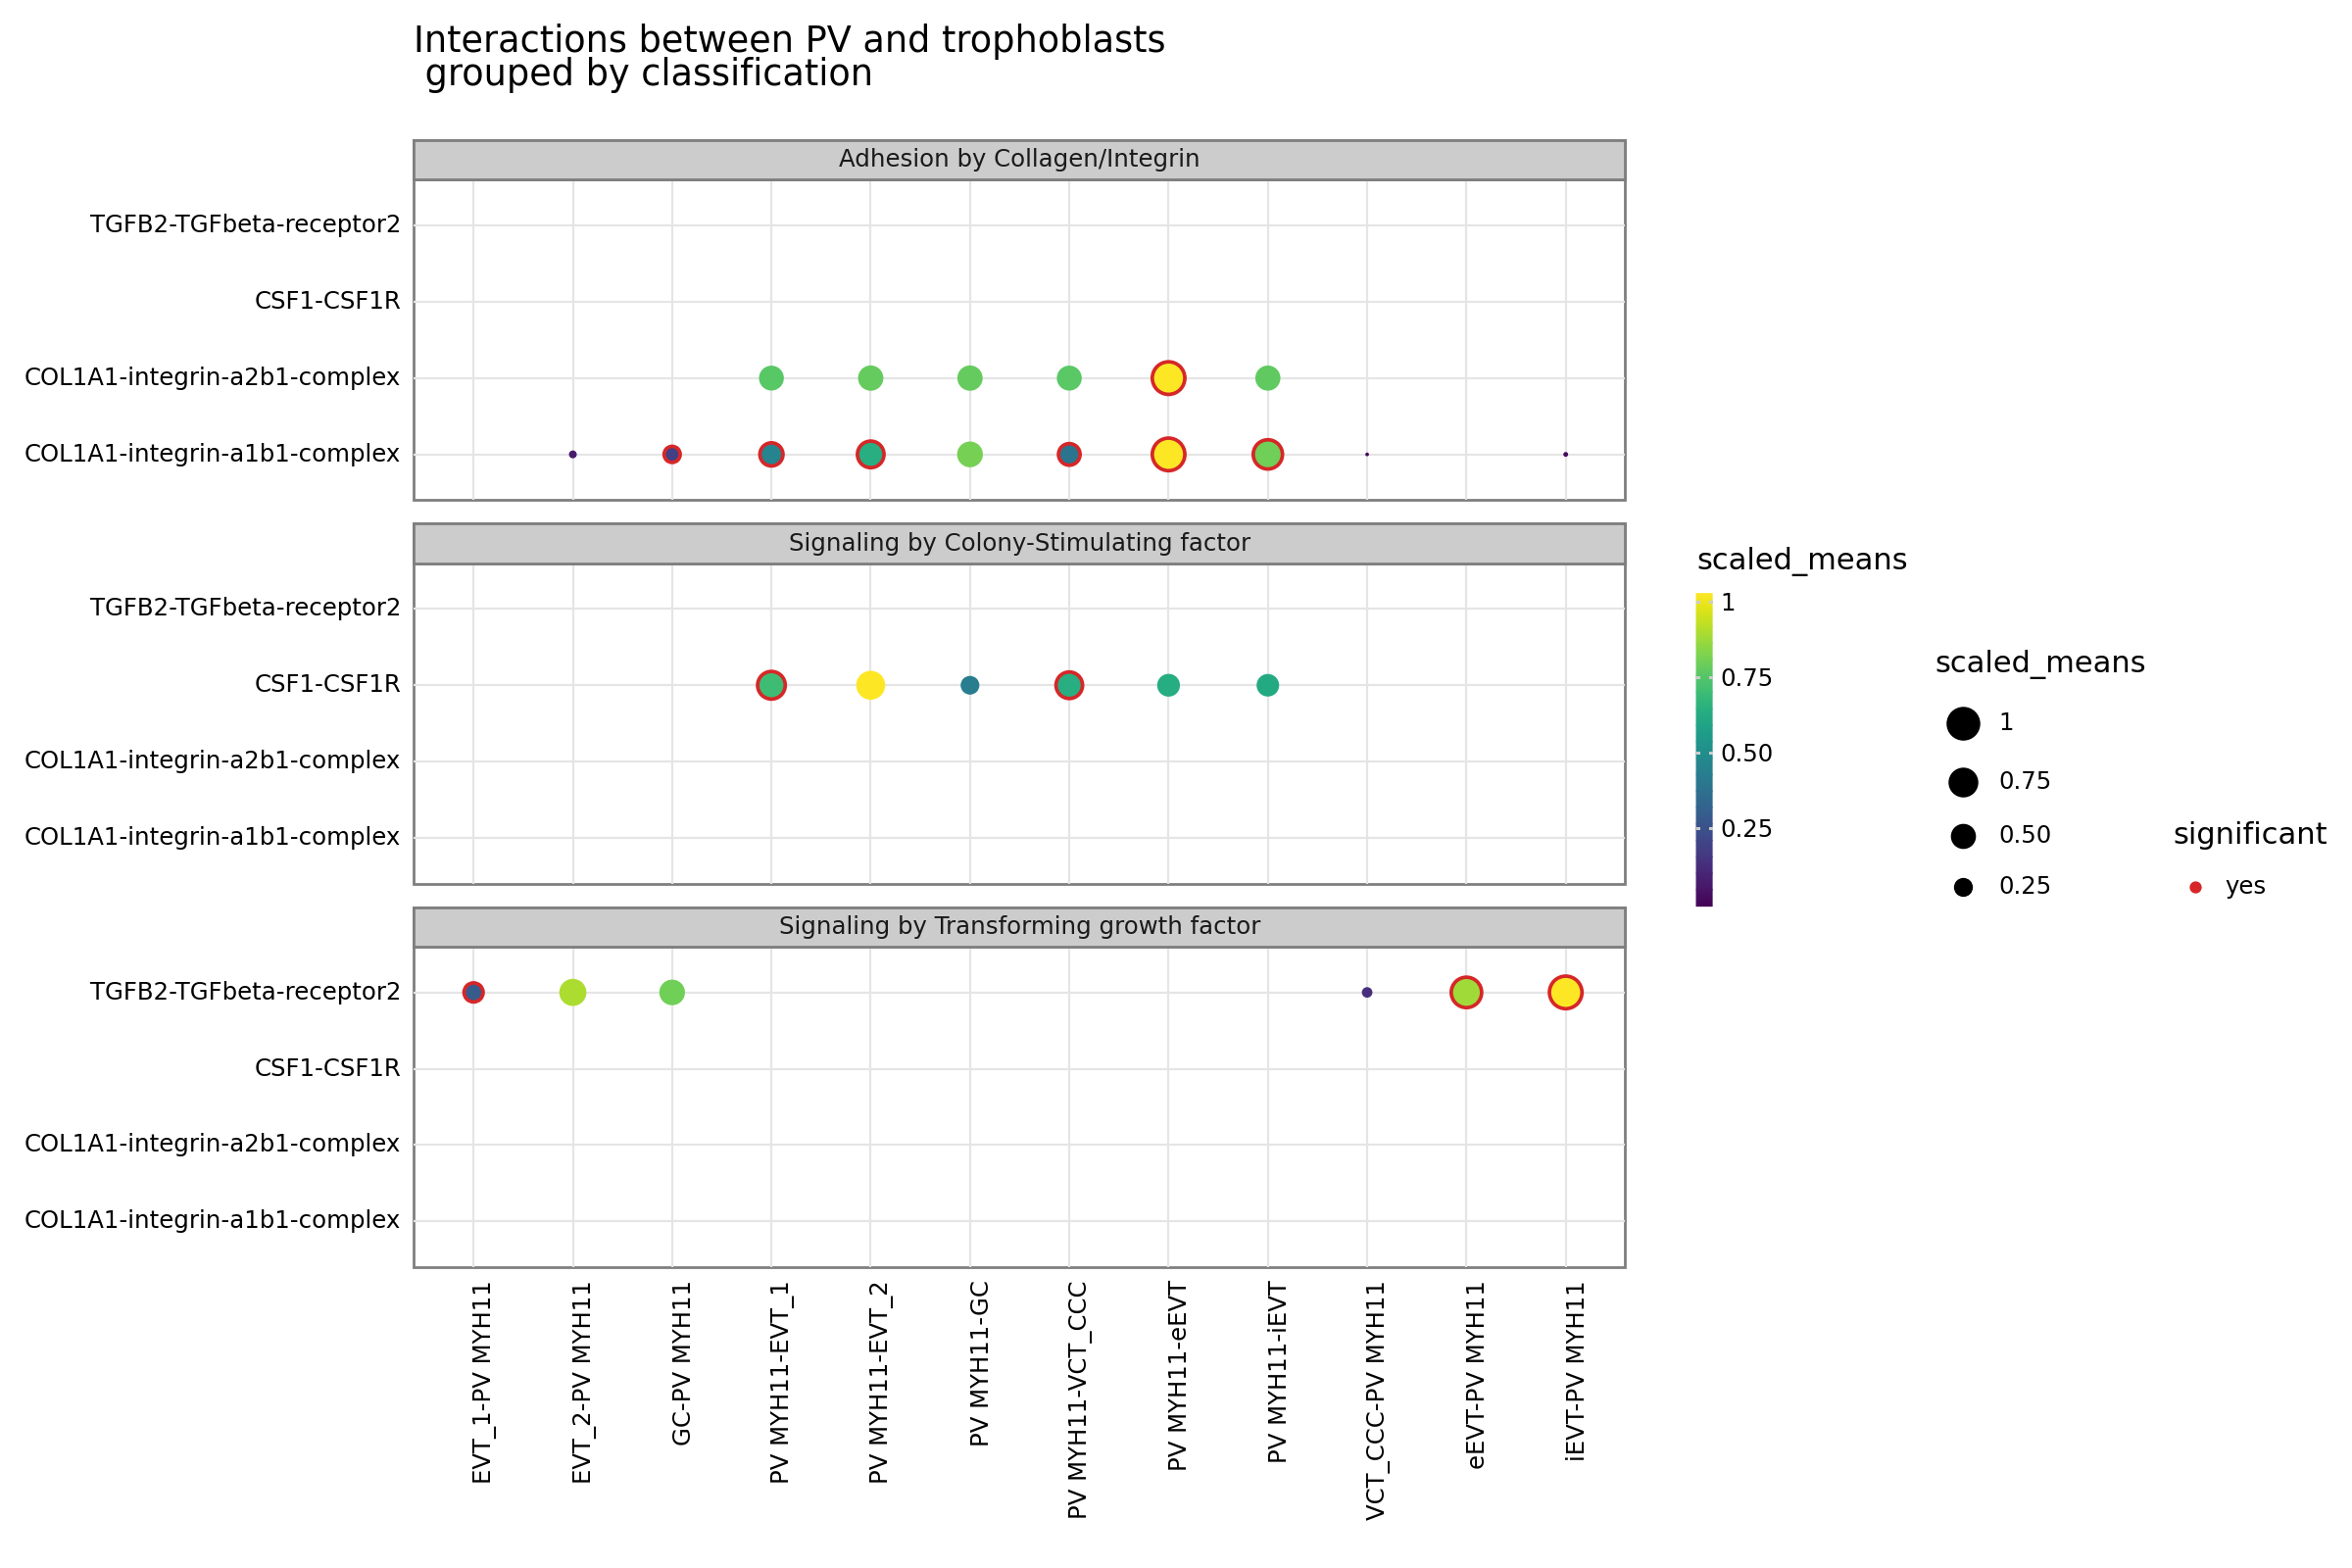

<Figure Size: (1200 x 800)>

In [32]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC",
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_labels",
    genes = ["TGFB2", "CSF1R", "COL1A1"],
    figsize = (12, 8),
    title = "Interactions between PV and trophoblasts\n grouped by classification",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True)

p + facet_wrap("~ classification", ncol = 1)